### Import Libraries



In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

Using TensorFlow backend.


### Connect to Drive



In [0]:
# Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### HyperParameters

In [0]:
BATCH_SIZE = 128 #@param ["512", "256", "128"] {type:"raw"}
MOMENTUM = 0.9 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
WEIGHT_DECAY = 0.000125 #@param ["0.000125", "0.00025", "0.0005"] {type:"raw"}
LEARNING_RATE = 0.4 #@param ["0.4", "0.2", "0.1"] {type:"raw"}
EPOCHS = 50 #@param {type:"slider", min:0, max:100, step:1}
WARMUP = 5 #@param {type:"slider", min:0, max:24, step:1}

### Read DataSet

In [0]:
from keras.datasets import cifar10
(train_X, train_y), (test_X, test_y) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_X.shape
num_test, _, _, _ =  test_X.shape
num_classes = len(np.unique(train_y))

In [0]:
print (num_classes)
print (num_train)
print (train_X.shape)

10
50000
(50000, 32, 32, 3)


### Classes

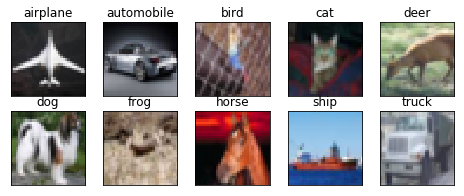

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_y[:]==i)[0]
    features_idx = train_X[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Functions for Post Training Analysis 

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Preparing Data

In [0]:
train_X = train_X.astype('float32')/255
test_X = test_X.astype('float32')/255
# convert class labels to binary class labels
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)

In [0]:
train_X_mean = np.mean(train_X, axis=(0,1,2))
train_X_std = np.std(train_X, axis=(0,1,2))
train_X = (train_X - train_X_mean) / train_X_std
test_X = (test_X - train_X_mean) / train_X_std

### Import Cutout

In [0]:
!wget "https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py"
from random_eraser import get_random_eraser

--2019-07-26 06:50:20--  https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888 [text/plain]
Saving to: ‘random_eraser.py’

random_eraser.py    100%[===================>]     888  --.-KB/s    in 0s      

2019-07-26 06:50:20 (110 MB/s) - ‘random_eraser.py’ saved [888/888]



### Image Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

traindatagen = ImageDataGenerator(zoom_range=0.0, #featurewise_center=True, featurewise_std_normalization=True,
                             width_shift_range=0.15625, height_shift_range=0.15625, rotation_range=15, horizontal_flip=True, 
                             preprocessing_function=get_random_eraser(s_l=0.25, s_h=0.25,v_l=0, v_h=1))
testdatagen = ImageDataGenerator()

train_generator = traindatagen.flow(train_X, train_y, batch_size = BATCH_SIZE)

### Define Model

In [81]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

### Model Summary

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### Compile Model

In [0]:
# Compile the model
model.compile(optimizer=SGD(lr=0.1, momentum=MOMENTUM, decay=WEIGHT_DECAY), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### One Cycle Learning Rate

#### Code

In [0]:
from keras.callbacks import Callback

class OneCycleLR(Callback):
    def __init__(self,
                 batch_size,
                 epochs,   
                 samples,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.

        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.

        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = epochs
        self.batch_size = batch_size
        self.samples = samples
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.

        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.

        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.

        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.

        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        self.epochs = self.epochs
        self.batch_size = self.batch_size
        self.samples = self.samples
#         self.steps = self.params['worlsteps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))

#### Initialize

In [0]:
lr_manager = OneCycleLR(batch_size=BATCH_SIZE, epochs=EPOCHS, samples=num_train,
                        max_lr=0.3, end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=0.95, minimum_momentum=0.85,verbose=1)

### Callback

In [84]:
from keras.callbacks import ModelCheckpoint
!mkdir "Assignment12"
filepath="Assignment12//maxAccuracy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [lr_manager,checkpoint]

mkdir: cannot create directory ‘Assignment12’: File exists


### Model Training

#### Max LR:0.5, 24 epochs, Acc: 82.84 stable

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=24, validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=97)`
  """


Epoch 1/24
 3/97 [..............................] - ETA: 1:28 - loss: 2.7733 - acc: 0.1530

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.303051). Check your callbacks.
  % delta_t_median)


97/97 [==============================] - 36s 368ms/step - loss: 1.9996 - acc: 0.3101 - val_loss: 5.0677 - val_acc: 0.1923
 - lr: 0.08934 - momentum: 0.94 

Epoch 00001: val_acc did not improve from 0.82840
Epoch 2/24
97/97 [==============================] - 33s 341ms/step - loss: 1.6254 - acc: 0.4312 - val_loss: 2.1029 - val_acc: 0.3902
 - lr: 0.12910 - momentum: 0.93 

Epoch 00002: val_acc did not improve from 0.82840
Epoch 3/24
97/97 [==============================] - 33s 343ms/step - loss: 1.4550 - acc: 0.5001 - val_loss: 1.9462 - val_acc: 0.4102
 - lr: 0.16885 - momentum: 0.92 

Epoch 00003: val_acc did not improve from 0.82840
Epoch 4/24
97/97 [==============================] - 33s 343ms/step - loss: 1.3011 - acc: 0.5623 - val_loss: 1.4093 - val_acc: 0.5585
 - lr: 0.20861 - momentum: 0.91 

Epoch 00004: val_acc did not improve from 0.82840
Epoch 5/24
97/97 [==============================] - 33s 341ms/step - loss: 1.2240 - acc: 0.5922 - val_loss: 1.3166 - val_acc: 0.5997
 - lr: 0.2

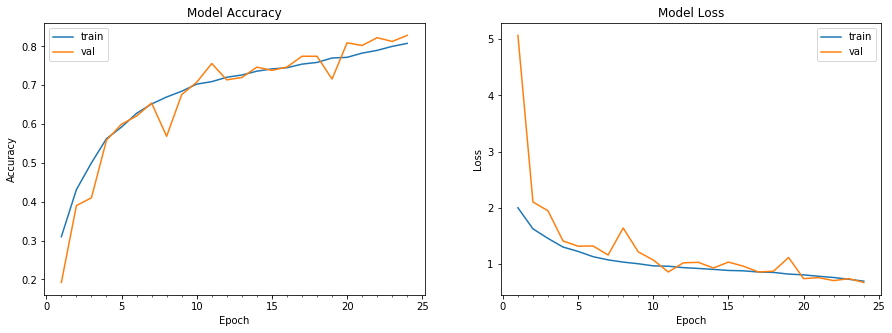

Accuracy on test data is: 82.84


In [0]:
# max_lr=0.5
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(train_generator, 
                                 samples_per_epoch = train_X.shape[0], epochs = EPOCHS, 
                                 validation_data = (test_X, test_y), verbose=1, callbacks=callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_X, test_y, model))

#### Max LR:0.3, 50 epochs, Acc: 87.33 stable

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=50, validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=390)`
  """


Epoch 1/50
  4/390 [..............................] - ETA: 4:06 - loss: 2.8814 - acc: 0.1629

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.300145). Check your callbacks.
  % delta_t_median)


390/390 [==============================] - 46s 117ms/step - loss: 1.8971 - acc: 0.3407 - val_loss: 2.2075 - val_acc: 0.3567
 - lr: 0.04172 - momentum: 0.95 

Epoch 00001: val_acc improved from -inf to 0.35670, saving model to Assignment12//maxAccuracy.hdf5
Epoch 2/50
390/390 [==============================] - 42s 108ms/step - loss: 1.4945 - acc: 0.4816 - val_loss: 1.5354 - val_acc: 0.4903
 - lr: 0.05346 - momentum: 0.94 

Epoch 00002: val_acc improved from 0.35670 to 0.49030, saving model to Assignment12//maxAccuracy.hdf5
Epoch 3/50
390/390 [==============================] - 42s 108ms/step - loss: 1.3487 - acc: 0.5431 - val_loss: 1.2571 - val_acc: 0.5957
 - lr: 0.06521 - momentum: 0.94 

Epoch 00003: val_acc improved from 0.49030 to 0.59570, saving model to Assignment12//maxAccuracy.hdf5
Epoch 4/50
390/390 [==============================] - 42s 108ms/step - loss: 1.2528 - acc: 0.5847 - val_loss: 1.0349 - val_acc: 0.6641
 - lr: 0.07696 - momentum: 0.93 

Epoch 00004: val_acc improved fr

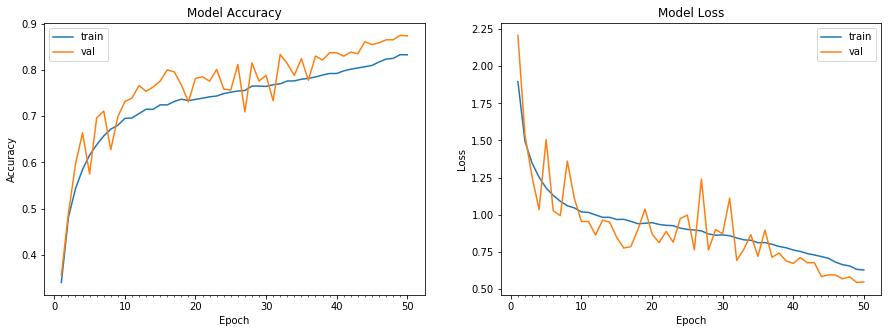

Accuracy on test data is: 87.33


In [85]:
# max_lr=0.3
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(train_generator, 
                                 samples_per_epoch = train_X.shape[0], epochs = EPOCHS, 
                                 validation_data = (test_X, test_y), verbose=1, callbacks=callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_X, test_y, model))

#### Save Model

In [0]:
model.load_weights('./Assignment12//maxAccuracy.hdf5')
model.save('./drive/My Drive/EVA/12a_CIFAR10-49-0.87.hdf5.h5')

#### Evaluate Model

In [89]:
model.load_weights('./drive/My Drive/EVA/12a_CIFAR10-49-0.87.hdf5.h5')
model.evaluate(test_X, test_y)

10000/10000 [==============================] - 4s 403us/step


[0.5444809146881103, 0.8745]